# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [1]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
end

  Activating project at `~/Downloads/sc/NoisyReach.jl`
Precompiling project...
   4755.7 ms  ✓ NoisyReach
  1 dependency successfully precompiled in 6 seconds. 369 already precompiled.


## 2. Physical System and Neural Networks Uncertainty Setup

In [2]:
sys = benchmarks[:F1]
const h   = 0.02
const Dc₁ = 0.005
const Dc₂ = 0.015
const σ₁  = 0.3
const σ₂  = 0.2
const μ   = 0.
const H   = 10
const N = 10000

10

In [3]:
sys_ideal, K_ideal = synthesize(sys, h)

(ControlSystemsBase.StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.13
 0.0  1.0
B = 
 0.025590551181102362
 0.3937007874015748
C = 
 1.0  0.0
D = 
 0.0

Sample Time: 0.02 (seconds)
Discrete-time state-space model, [0.7770441104269344 1.0568620913227746])

In [4]:
sys_aug, K_aug = synthesize(sys, h, Dc₁, Dc₂)

(ControlSystemsBase.StateSpace{ControlSystemsBase.Discrete{Float64}, Float64}
A = 
 1.0  0.13  0.004798228346456696
 0.0  1.0   0.09842519685039372
 0.0  0.0   0.0
B = 
 0.00639763779527559  0.0015994094488188985
 0.19685039370078738  0.09842519685039372
 0.0                  1.0
C = 
 1.0  0.0  0.0
D = 
 0.0  0.0

Sample Time: 0.02 (seconds)
Discrete-time state-space model, [0.7254833395010615 1.1184050293956818 0.10427751063594676; 0.30475400590045454 0.4932526972396232 0.04611136163978451])

In [5]:
x₀ = fill(1., size(sys.A, 1))

2-element Vector{Float64}:
 1.0
 1.0

In [6]:
z₀ = [fill(1., size(sys.A, 1)); 0.]

3-element Vector{Float64}:
 1.0
 1.0
 0.0

## 3. Calculate and Plot Reachable Trajectories

In [7]:
all_trajectories_z = []
all_trajectories_u = []
for i in 1:10000
    z, u = simulate(sys_aug, K_uncertain(K_aug, σ₁, σ₂, μ), H, z₀)
    push!(all_trajectories_z, z)
    push!(all_trajectories_u, u)
end
z_ideal, u_ideal = simulate(sys_ideal, K_ideal, H, x₀)

([[1.0, 1.0], [1.176930670517217, 1.722010315649492], [1.470768208602789, 2.798567193359311], [1.9395173129574657, 4.412957489020335], [2.671120514514951, 6.842476381094825], [3.7988170911162045, 10.506701720462924], [5.524388672267808, 16.040553374177122], [8.153340737022116, 24.40486300665838], [12.148148202343824, 37.053713382906345], [18.20883971455207, 56.18769449722048], [27.394957140176754, 85.13718897392849]], [[1.8339062017497092], [2.7344544693829396], [4.100551350979], [6.170977985869204], [9.307132361994972], [14.055983200434067], [21.245346466502397], [32.12807995566983], [48.600312030357905], [73.53171597083835]])

In [8]:
const xlim = 60
const ylim = 250
Plots.scalefontsizes(1.8)

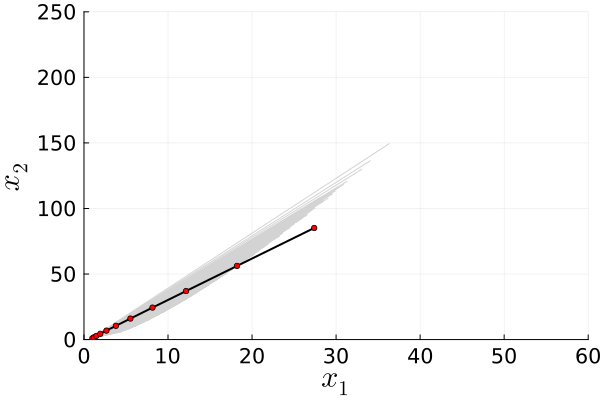

In [9]:
traj_plot = plot(xlabel="\$x_1\$", ylabel="\$x_2\$")#, title="x Trajectories")
for trajectory in all_trajectories_z
    x_z = [point[1] for point in trajectory]
    y_z = [point[2] for point in trajectory]
    
    plot!(x_z, y_z, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
end
x_z_ideal = [point[1] for point in z_ideal]
y_z_ideal = [point[2] for point in z_ideal]
plot!(x_z_ideal, y_z_ideal, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=3)
display(traj_plot)
#savefig(traj_plot, "moreNN1.svg")

In [10]:
maximum(x -> maximum(_x -> _x[1], x), all_trajectories_z)

36.31578334254965

In [11]:
maximum(x -> maximum(_x -> _x[2], x), all_trajectories_z)

149.4209945884777

In [15]:
maximum(trajectory_u -> maximum(u -> (abs(u[1]),abs(u[2])), trajectory_u), all_trajectories_u)

(227.2152911311758, 80.68419135901775)

In [13]:
maximum(x -> x[1], u_ideal)

73.53171597083835